# Bomberle: Game Mechanics Explained

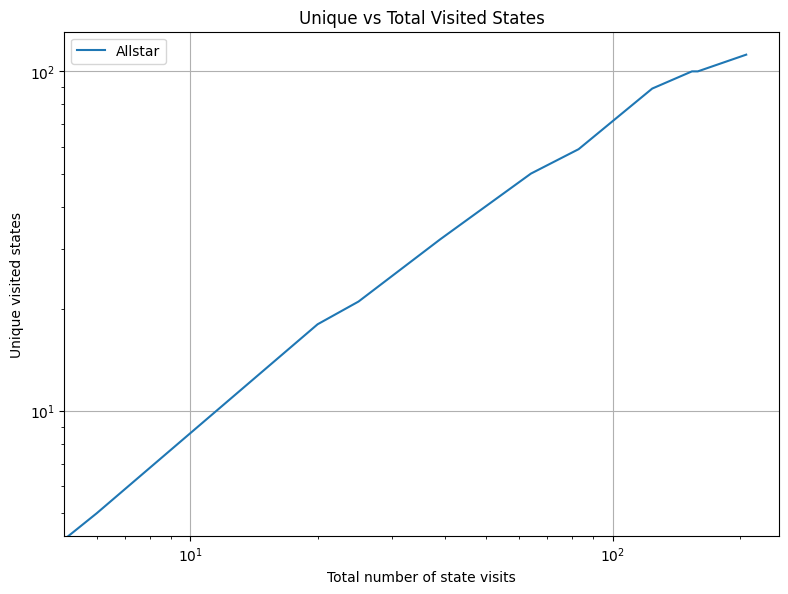

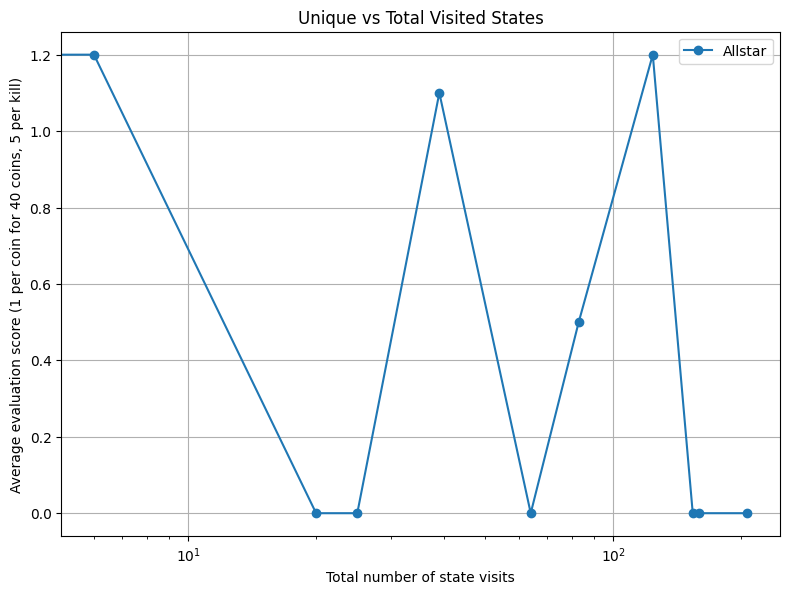

In [ ]:
#!/usr/bin/env python3
import os
import pickle
import re
import matplotlib.pyplot as plt
import json
import numpy as np

def load_q_visits_snapshots(folder):
    """Load q_visits snapshots and matching evaluation results."""
    q_pattern = re.compile(r"q_visits_chunk_(\d+)\.pkl$")
    eval_pattern = re.compile(r"eval_chunk_(\d+)\.json$")

    # Match chunk IDs to file paths
    q_files = {}
    eval_files = {}
    for f in os.listdir(folder):
        m_q = q_pattern.match(f)
        if m_q:
            q_files[int(m_q.group(1))] = os.path.join(folder, f)
        m_e = eval_pattern.match(f)
        if m_e:
            eval_files[int(m_e.group(1))] = os.path.join(folder, f)

    chunk_indices = sorted(set(q_files.keys()) & set(eval_files.keys()))

    total_counts = []
    unique_counts = []
    avg_scores = []

    for idx in chunk_indices:
        # --- Load Q-visits ---
        with open(q_files[idx], "rb") as f:
            q_visits = pickle.load(f)

        total_visits = sum(np.sum(v) for v in q_visits.values())
        unique_states = len(q_visits)

        # --- Load Evaluation JSON ---
        with open(eval_files[idx], "r") as f:
            data = json.load(f)

        # ✅ Extract the agent with 'tq' in the name
        tq_agent_data = None
        for agent_name, agent_stats in data.get("by_agent", {}).items():
            if "tq" in agent_name:
                tq_agent_data = agent_stats
                break

        if tq_agent_data is None:
            raise ValueError(f"No agent containing 'tq' found in chunk {idx}")

        # Use whatever stats you want from tq_agent_data
        # Example: reward heuristic = coins + 5 * kills (if present)
        coins = tq_agent_data.get("coins", 0)
        kills = tq_agent_data.get("kills", 0)
        score = tq_agent_data.get("score", 0)  # optionally use this instead

        avg_score = score/ tq_agent_data.get("rounds", 1)

        # Append metrics
        total_counts.append(total_visits)
        unique_counts.append(unique_states)
        avg_scores.append(avg_score)
    return chunk_indices, total_counts, unique_counts, avg_scores


dict1_folder = "agent_code/tq_coingrabber/dicts"  # change this to your actual dicts folder
dict2_folder = "agent_code/tq_cratehero/dicts"  # change this to your actual dicts folder
dict3_folder = "agent_code/tq_allstar/dicts"  # change this to your actual dicts folder

c1, t1, u1, a1 = load_q_visits_snapshots(dict1_folder)
c2, t2, u2, a2 = load_q_visits_snapshots(dict2_folder)
c3, t3, u3, a3 = load_q_visits_snapshots(dict3_folder)


plt.figure(figsize=(8,6))
plt.plot(t1, u1, label = "Coingrabber")
plt.plot(t2, u2, label = "Cratehero")
plt.plot(t3, u3, label = "Allstar")
plt.xlabel("Total number of state visits")
plt.ylabel("Unique visited states")
plt.title("Unique vs Total Visited States")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(t1, a1, label="Coingrabber", marker="o")
plt.plot(t2, a2, label="Cratehero", marker="o")
plt.plot(t3, a3, label="Allstar", marker="o")
plt.xlabel("Total number of state visits")
plt.ylabel("Average evaluation score (1 per coin for 40 coins, 5 per kill)")
plt.title("Unique vs Total Visited States")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xscale("log")
plt.show()



# Typical old run

`alpha = max(5e-4, min(self.learning_rate, 1.0 / (1 + self.q_visits[state][action])))`

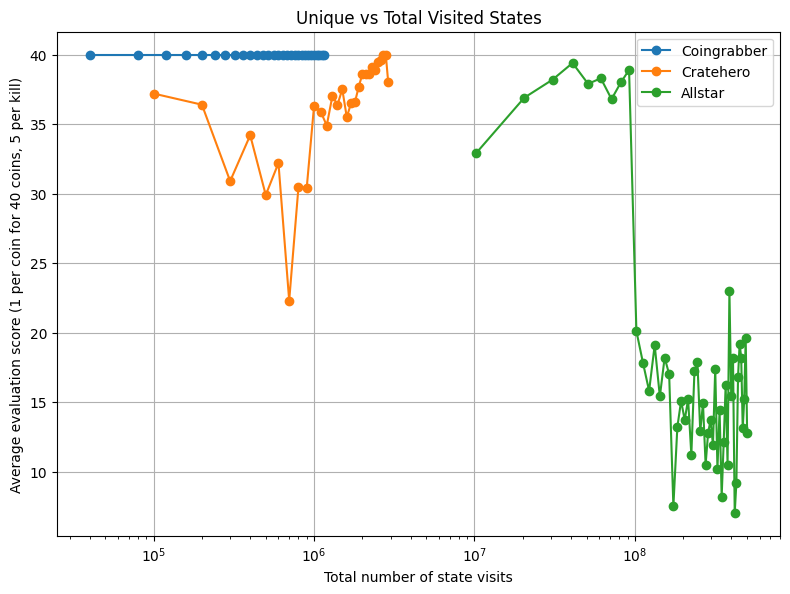

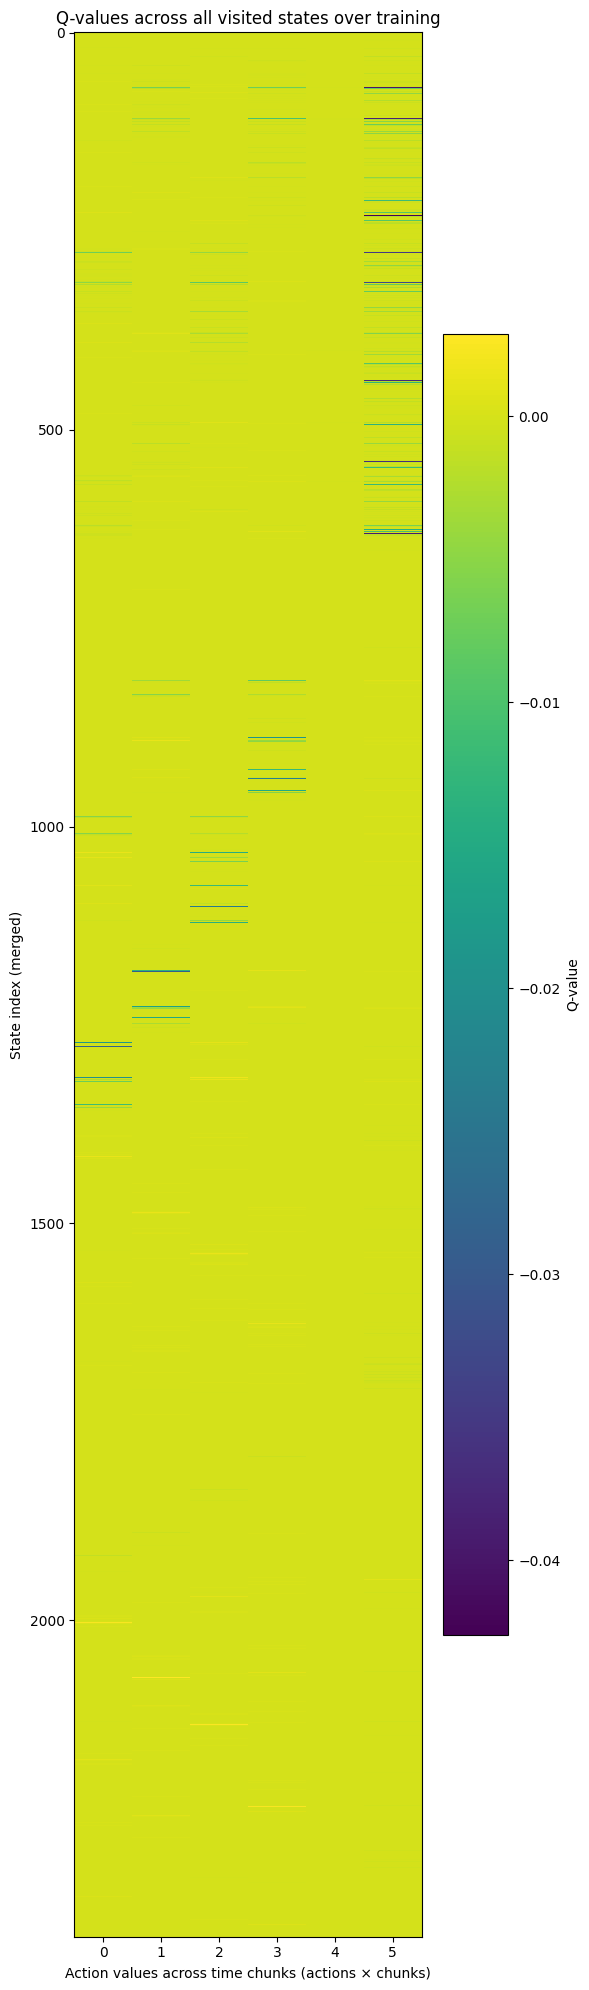

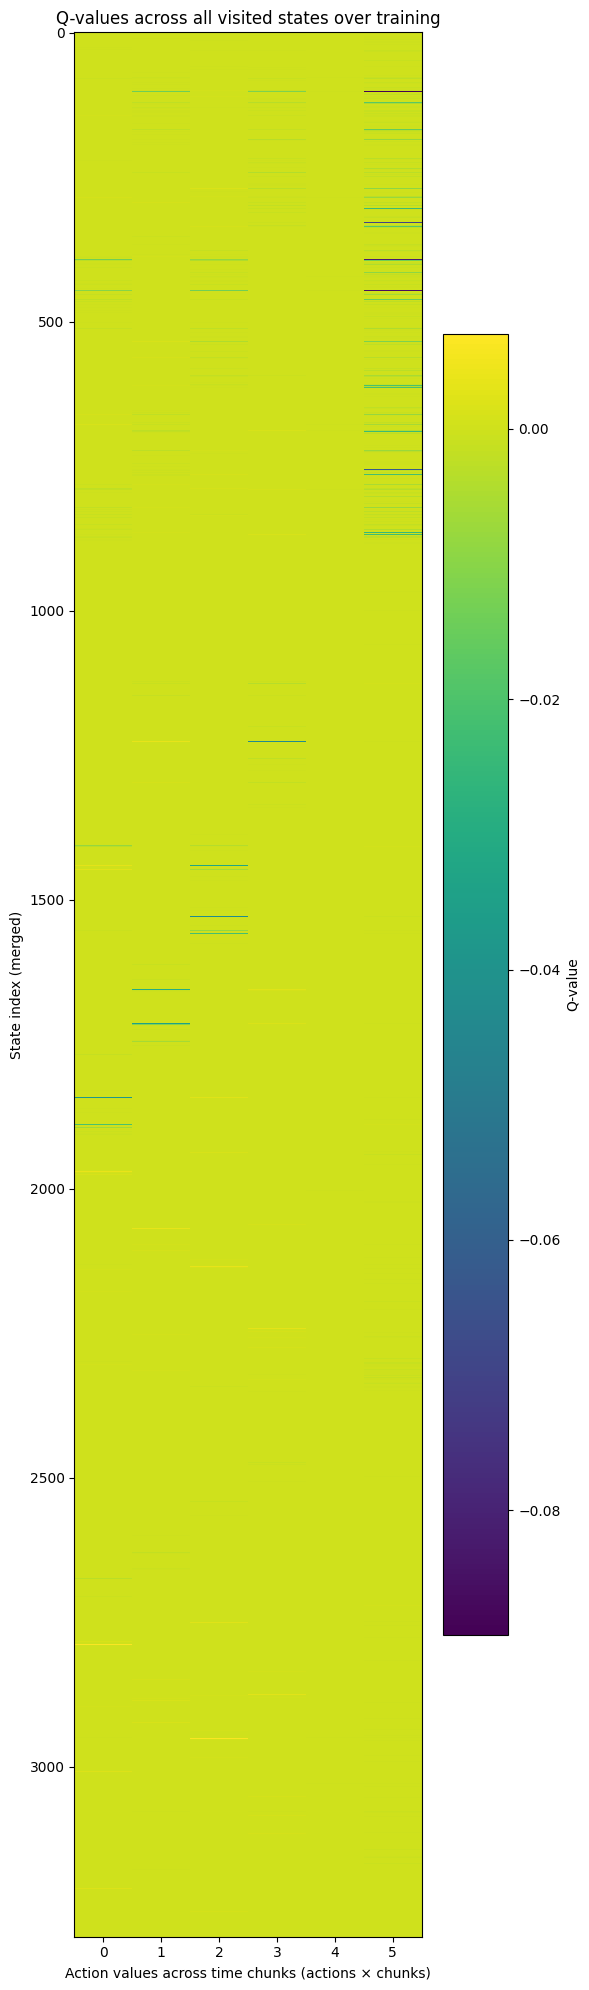

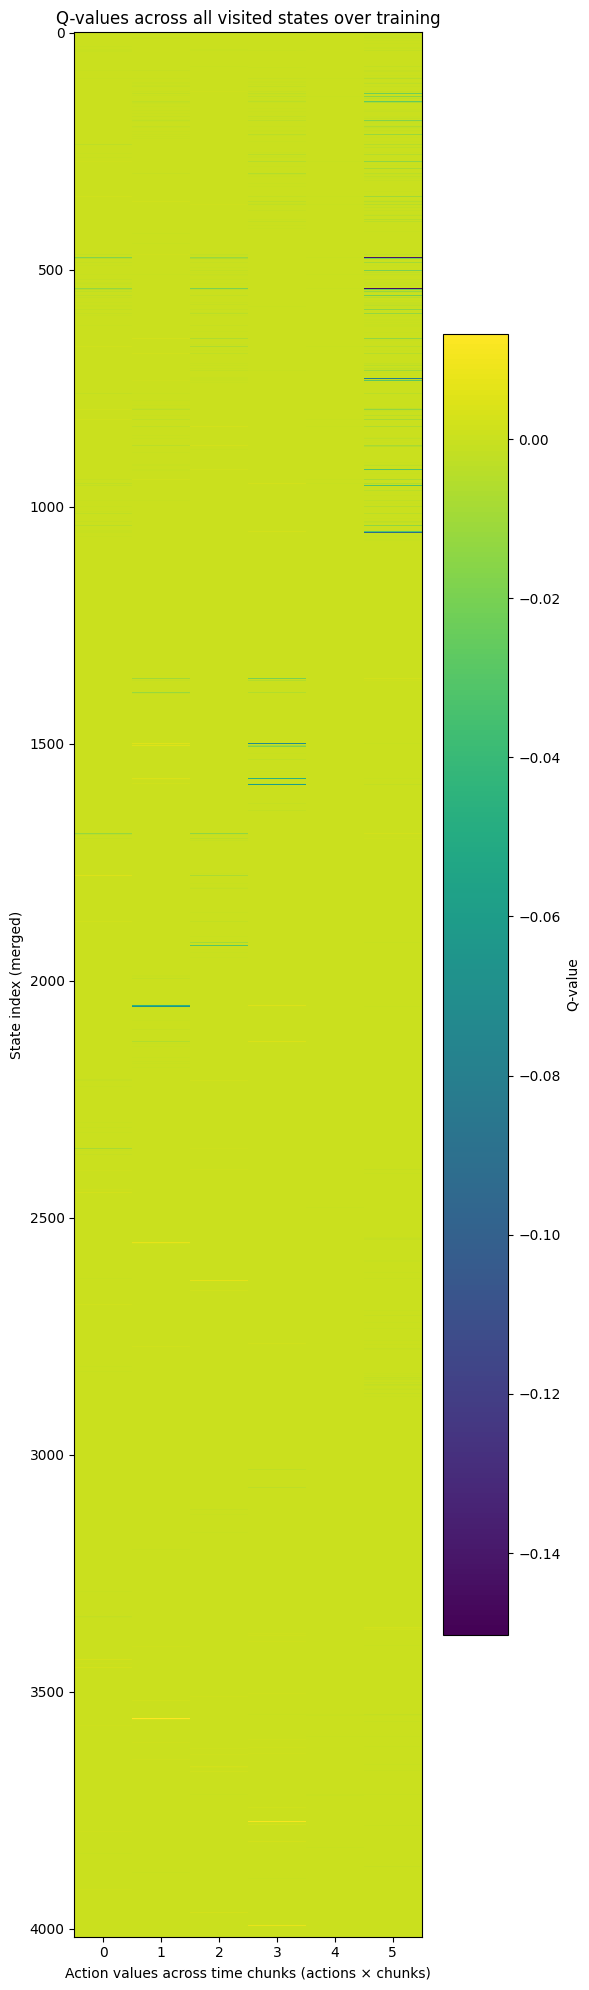

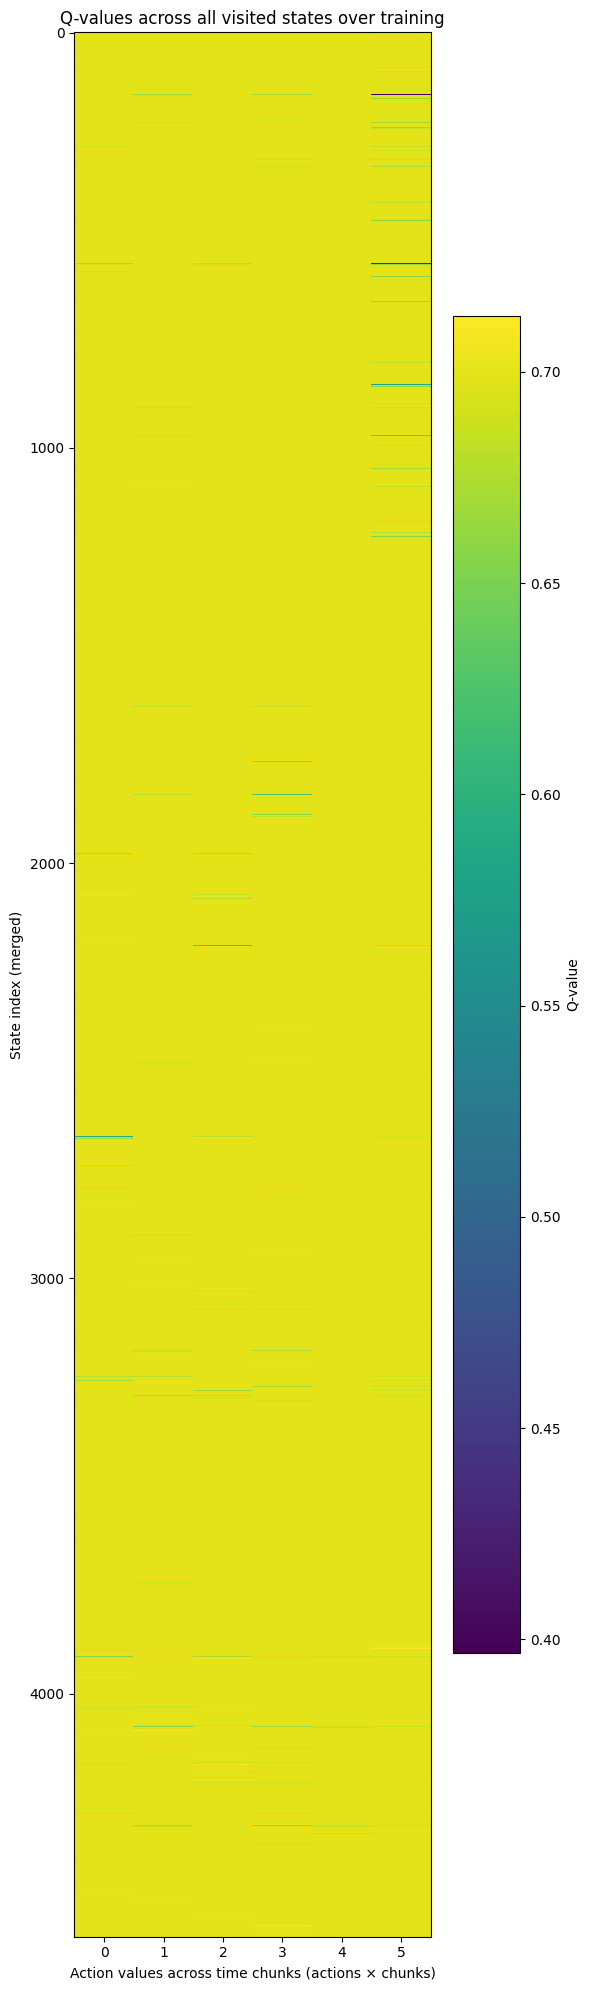

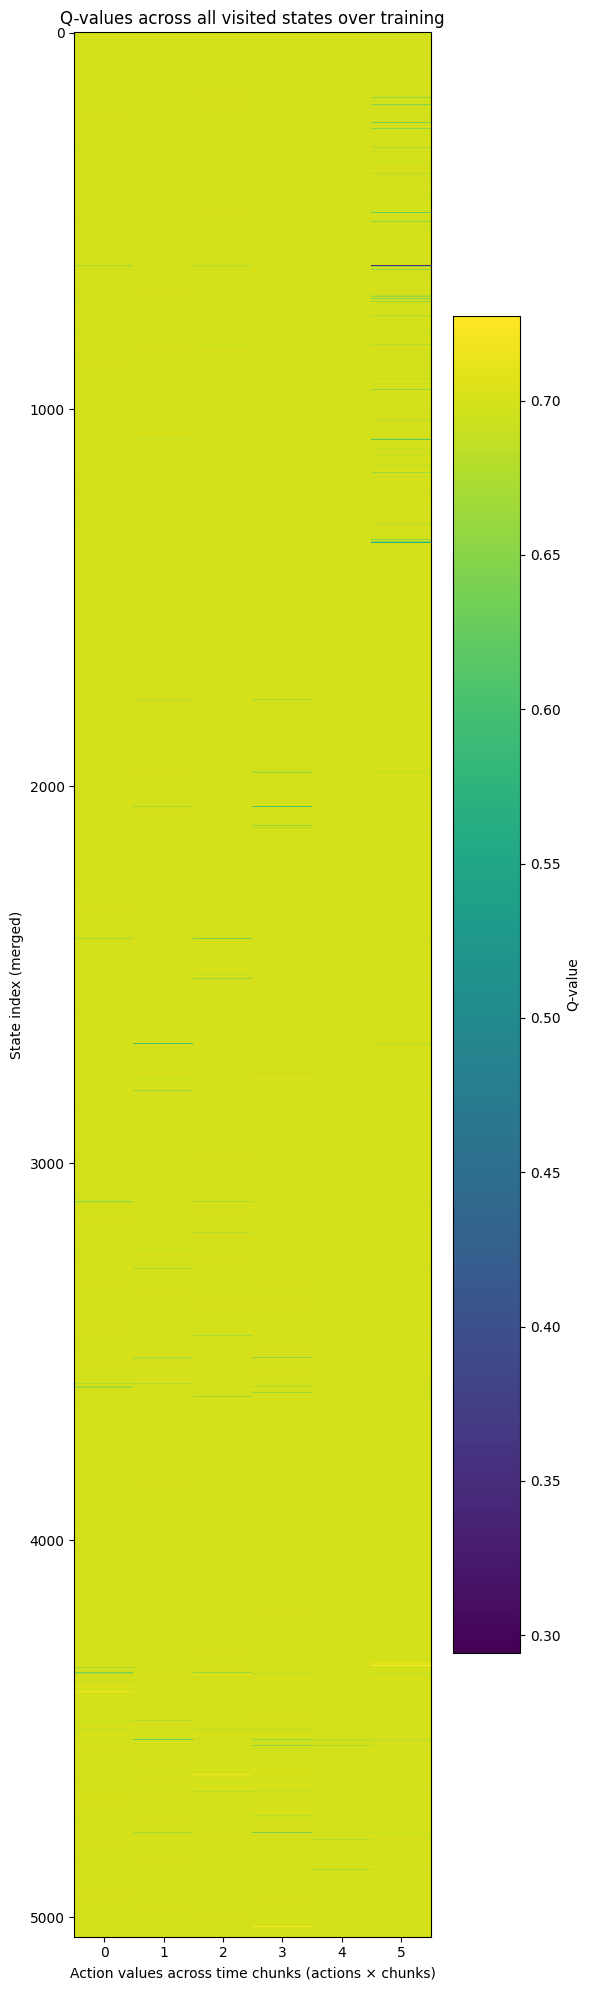

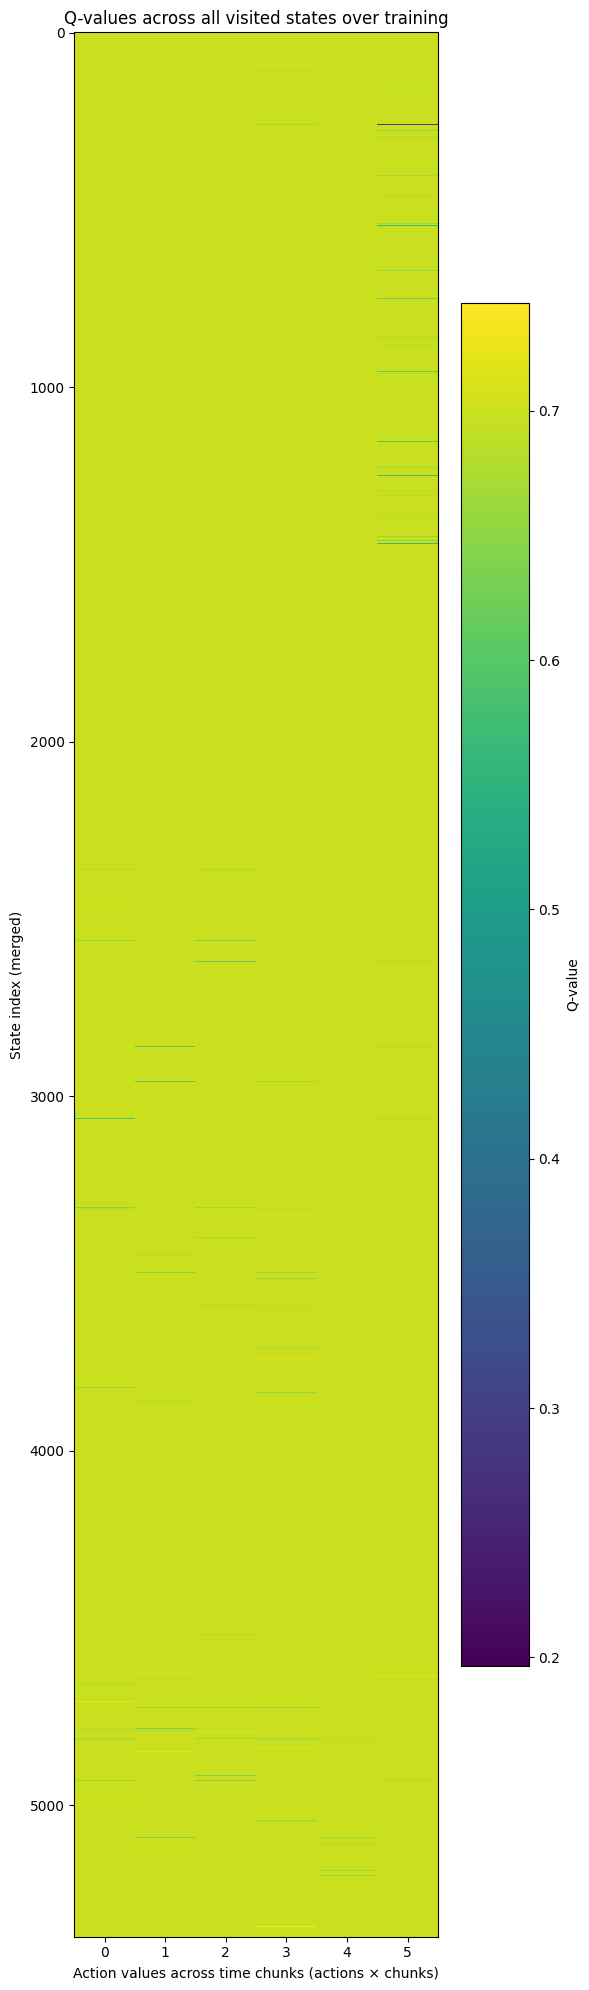

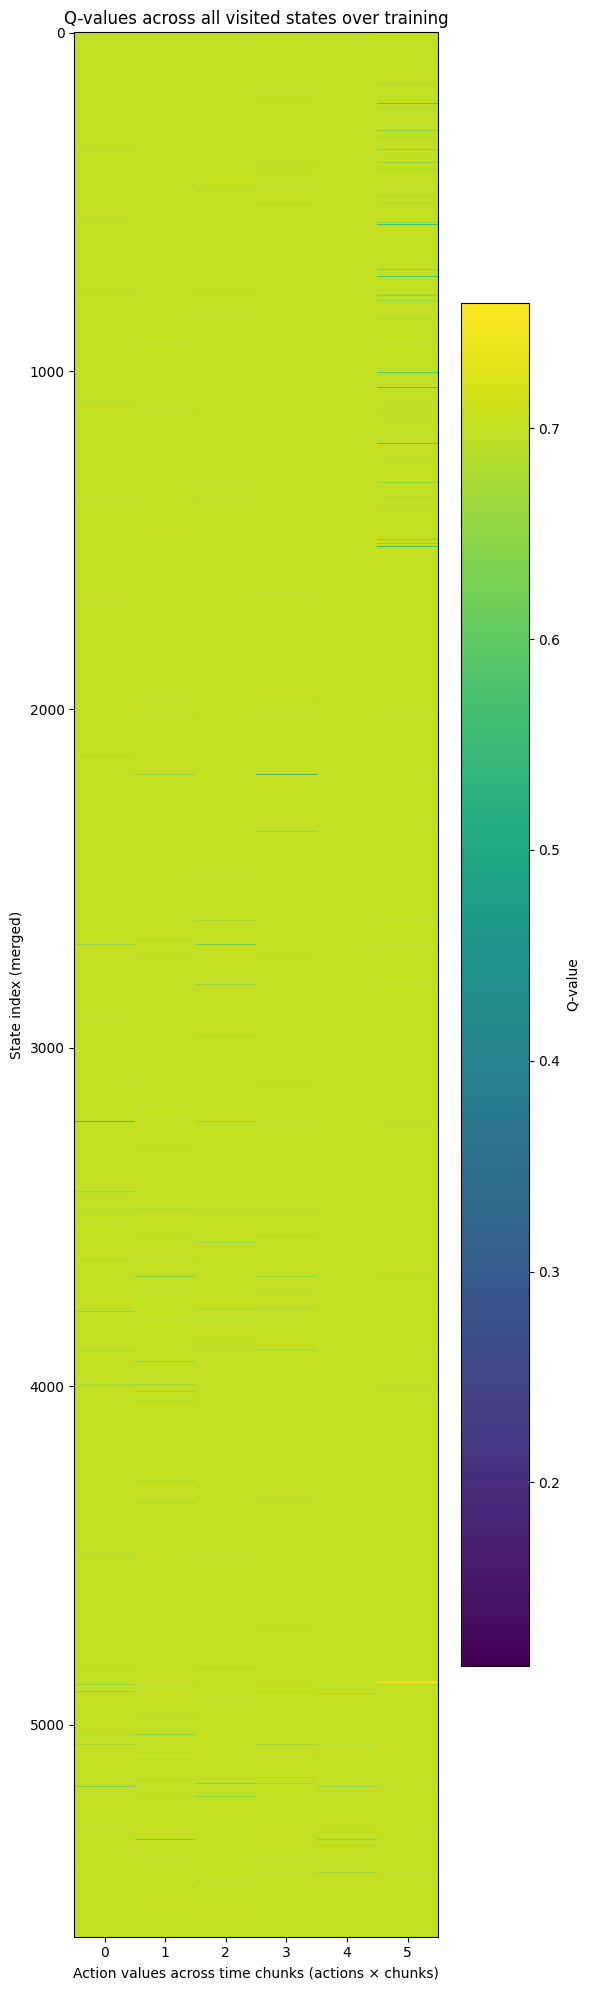

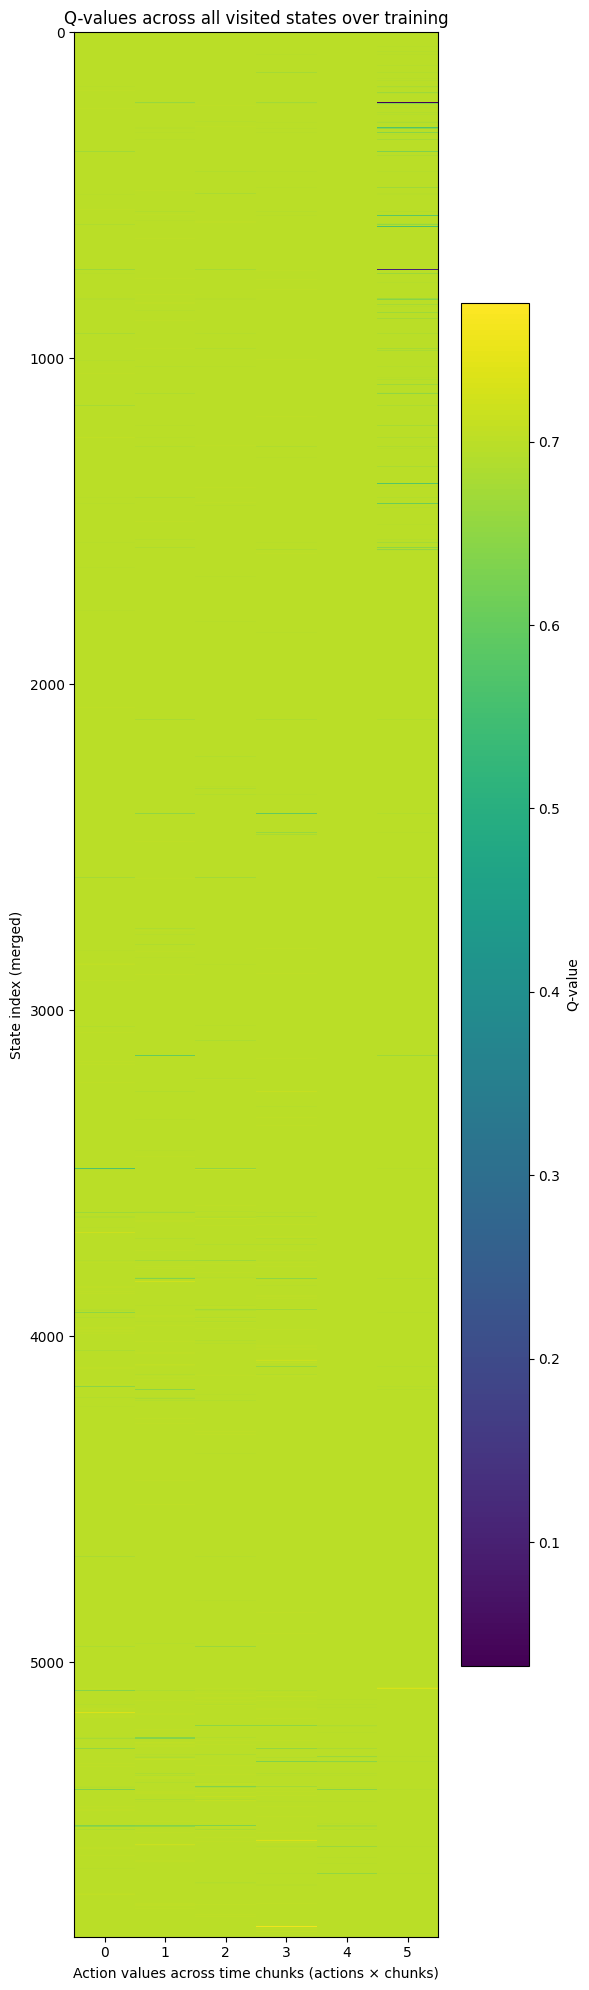

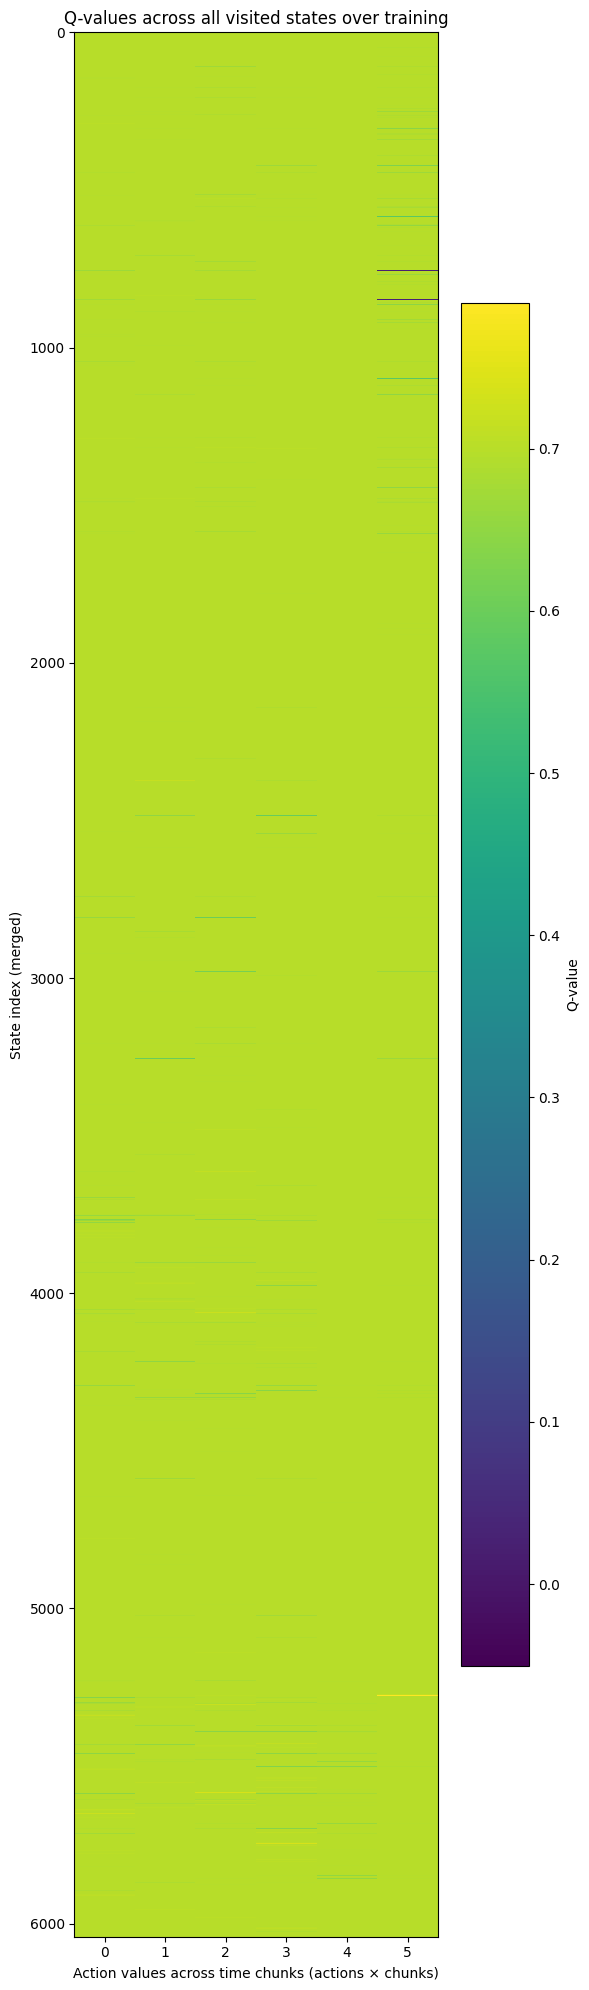

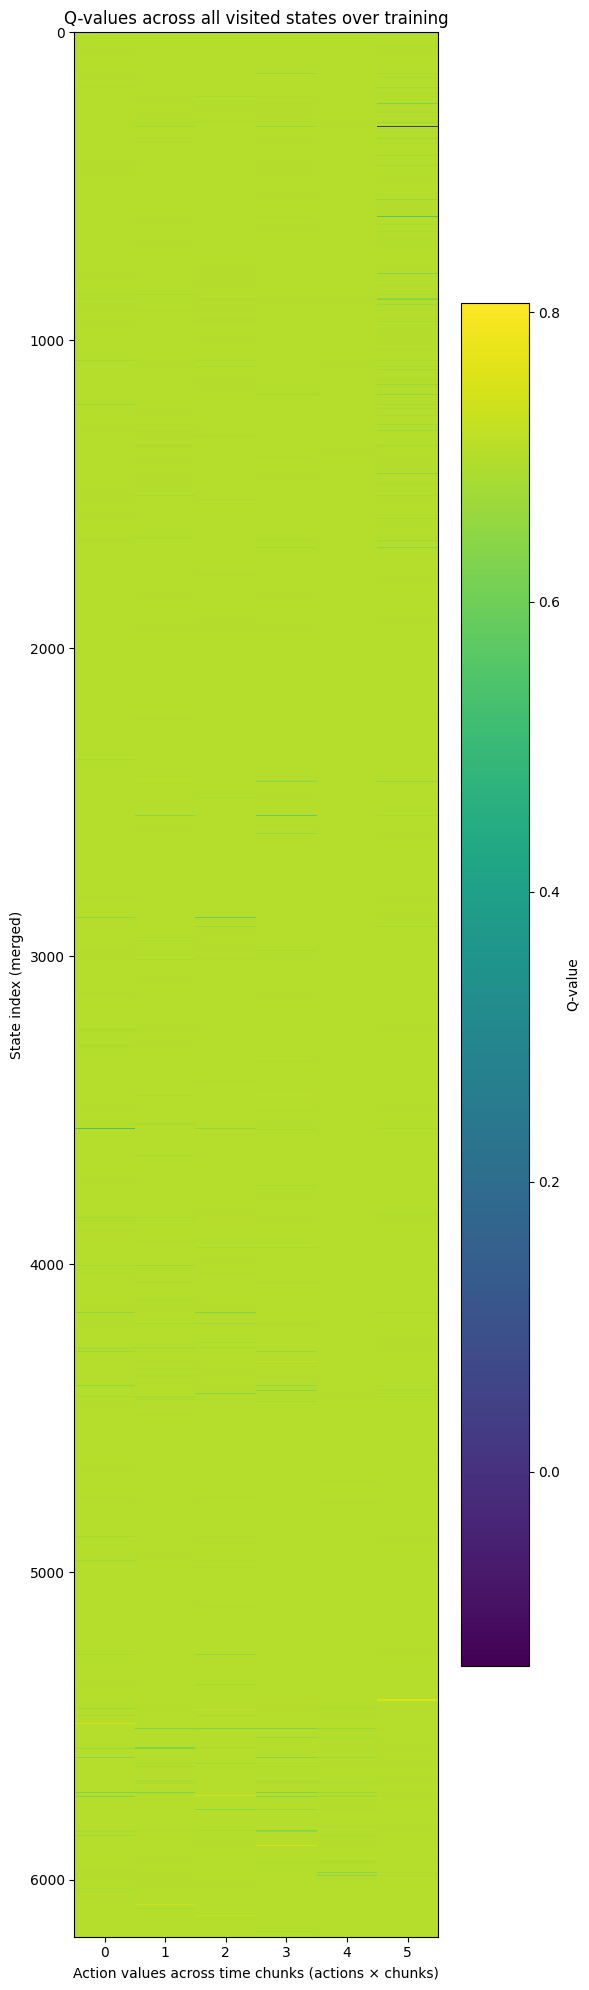

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def load_q_snapshots(folder):
    """Load all q_chunk_*.pkl files in order of chunk index."""
    q_pattern = re.compile(r"q_chunk_(\d+)\.pkl$")
    q_files = {}

    for f in os.listdir(folder):
        m = q_pattern.match(f)
        if m:
            q_files[int(m.group(1))] = os.path.join(folder, f)

    return [(idx, pickle.load(open(path, "rb"))) for idx, path in sorted(q_files.items())]


def plot_q_imshow_over_time(q_snapshots):
    """
    Show all visited states across training as an imshow plot with time on x-axis,
    states on y-axis, and Q-values as color.
    """
    chunk_indices = []
    q_data = []

    for chunk_idx, q_dict in q_snapshots:
        chunk_indices.append(chunk_idx)

        # Sort by state index to make it visually consistent
        states = sorted(q_dict.keys())
        q_matrix = np.array([q_dict[s] for s in states])  # shape: [num_states, num_actions]



        # Plot
        plt.figure(figsize=(6, 20))
        im = plt.imshow(q_matrix, aspect='auto', cmap='viridis', interpolation='none')

        plt.title("Q-values across all visited states over training")
        plt.xlabel("Action values across time chunks (actions × chunks)")
        plt.ylabel("State index (merged)")
        plt.colorbar(im, label="Q-value")


        plt.tight_layout()
        plt.show()

q_snapshots = load_q_snapshots("agent_code/tq_allstar/dicts")
plot_q_imshow_over_time(q_snapshots)


## Figure 2

In [ ]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/explain_bombs'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files

# Optional: Resize and convert to optimized palette with dithering
target_size = (512, 512)

image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -40)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    frames.append(cropped.convert('RGB').convert('P', palette=Image.ADAPTIVE, dither=Image.NONE))

# Save to GIF
output_path = 'figures/2_explain_bombs.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 09-46-17)_00001.png', 'Round 01 (2025-07-24 09-46-17)_00002.png', 'Round 01 (2025-07-24 09-46-17)_00003.png', 'Round 01 (2025-07-24 09-46-17)_00004.png', 'Round 01 (2025-07-24 09-46-17)_00005.png', 'Round 01 (2025-07-24 09-46-17)_00006.png', 'Round 01 (2025-07-24 09-46-17)_00007.png', 'Round 01 (2025-07-24 09-46-17)_00008.png', 'Round 01 (2025-07-24 09-46-17)_00009.png', 'Round 01 (2025-07-24 09-46-17)_00010.png', 'Round 01 (2025-07-24 09-46-17)_00011.png', 'Round 01 (2025-07-24 09-46-17)_00012.png', 'Round 01 (2025-07-24 09-46-17)_00013.png', 'Round 01 (2025-07-24 09-46-17)_00014.png', 'Round 01 (2025-07-24 09-46-17)_00015.png', 'Round 01 (2025-07-24 09-46-17)_00016.png', 'Round 01 (2025-07-24 09-46-17)_00017.png', 'Round 01 (2025-07-24 09-46-17)_00018.png', 'Round 01 (2025-07-24 09-46-17)_00019.png', 'Round 01 (2025-07-24 09-46-17)_00020.png', 'Round 01 (2025-07-24 09-46-17)_00021.png', 'Round 01 (2025-07-24 09-46-17)_00022.png', 'Round 01 (2025-07-24 09-46-17)

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os
import re

# Folder containing images
folder = 'screenshots/explain_bombs'

# Filename pattern
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# Collect and sort files
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Resize/crop parameters
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

# Stage labels
stage_labels = {
    1: "",
    2: "Frame 0: Move",
    3: "Frame 1: Agent drops the bomb",
    4: "Frame 2: Bomb ticking",
    5: "Frame 3: Bomb ticking",
    6: "Frame 4: Bomb ticking",
    7: "Frame 5: Bomb explodes",
    8: "Frame 6: Explosion remains",
    9: "Frame 7: Agent can place a new bomb",
}

# Load font (fallback if PT Serif not available)
font_size = 16
try:
    font = ImageFont.truetype("fonts/PTSerif-Bold.ttf", font_size)
except IOError:
    ImageFont.load_default()

# Process frames
frames = []
for idx, filename in enumerate(files):
    frame_num = idx + 1
    path = os.path.join(folder, filename)
    img = Image.open(path)
    width, height = img.size

    # Compute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]
    bottom = height + CROP_BOX[3]
    cropped = img.crop((left, top, right, bottom))

    # Create new image with white border
    border_size = 8
    bordered = Image.new("RGB", (cropped.width + 2 * border_size, cropped.height + 2 * border_size), "white")
    bordered.paste(cropped, (border_size, border_size))

    # Draw annotation
    draw = ImageDraw.Draw(bordered)
    text = stage_labels.get(frame_num, "")
    text_width, text_height = draw.textsize(text, font=font)
    text_position = ((bordered.width - text_width) // 2, 10)
    draw.text(text_position, text, fill="white", font=font, stroke_width=2, stroke_fill="black")

    # Convert to optimized palette for GIF
    palettized = bordered.convert('RGB').convert('P', palette=Image.ADAPTIVE, dither=Image.NONE)
    frames.append(palettized)

# Save GIF
output_path = 'figures/2_explain_bombs.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=1500,
    loop=0,
    optimize=True
)


['Round 01 (2025-07-24 09-46-17)_00001.png', 'Round 01 (2025-07-24 09-46-17)_00012.png', 'Round 01 (2025-07-24 09-46-17)_00019.png', 'Round 01 (2025-07-24 09-46-17)_00025.png', 'Round 01 (2025-07-24 09-46-17)_00035.png', 'Round 01 (2025-07-24 09-46-17)_00043.png', 'Round 01 (2025-07-24 09-46-17)_00053.png', 'Round 01 (2025-07-24 09-46-17)_00067.png', 'Round 01 (2025-07-24 09-46-17)_00079.png']


## Figure 3

In [47]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/coin_grabber'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with white border
    border_size = 8
    bordered = Image.new("RGB", (cropped.width + 2 * border_size, cropped.height + 2 * border_size), "white")
    bordered.paste(cropped, (border_size, border_size))


    frames.append(bordered.convert('RGB').convert('P', palette=Image.ADAPTIVE, dither=Image.NONE))

# Save to GIF
output_path = 'figures/3_coin_grabber.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 13-44-56)_00001.png', 'Round 01 (2025-07-24 13-44-56)_00002.png', 'Round 01 (2025-07-24 13-44-56)_00003.png', 'Round 01 (2025-07-24 13-44-56)_00004.png', 'Round 01 (2025-07-24 13-44-56)_00005.png', 'Round 01 (2025-07-24 13-44-56)_00006.png', 'Round 01 (2025-07-24 13-44-56)_00007.png', 'Round 01 (2025-07-24 13-44-56)_00008.png', 'Round 01 (2025-07-24 13-44-56)_00009.png', 'Round 01 (2025-07-24 13-44-56)_00010.png', 'Round 01 (2025-07-24 13-44-56)_00011.png', 'Round 01 (2025-07-24 13-44-56)_00012.png', 'Round 01 (2025-07-24 13-44-56)_00013.png', 'Round 01 (2025-07-24 13-44-56)_00014.png', 'Round 01 (2025-07-24 13-44-56)_00015.png', 'Round 01 (2025-07-24 13-44-56)_00016.png', 'Round 01 (2025-07-24 13-44-56)_00017.png', 'Round 01 (2025-07-24 13-44-56)_00018.png', 'Round 01 (2025-07-24 13-44-56)_00019.png', 'Round 01 (2025-07-24 13-44-56)_00020.png', 'Round 01 (2025-07-24 13-44-56)_00021.png', 'Round 01 (2025-07-24 13-44-56)_00022.png', 'Round 01 (2025-07-24 13-44-56)

## Figure 4

In [1]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/crate_hero'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with white border
    border_size = 8
    bordered = Image.new("RGB", (cropped.width + 2 * border_size, cropped.height + 2 * border_size), "white")
    bordered.paste(cropped, (border_size, border_size))


    frames.append(bordered.convert('RGB').convert('P', palette=Image.ADAPTIVE, dither=Image.NONE))

# Save to GIF
output_path = 'figures/4_crate_hero.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 15-51-29)_00001.png', 'Round 01 (2025-07-24 15-51-29)_00002.png', 'Round 01 (2025-07-24 15-51-29)_00003.png', 'Round 01 (2025-07-24 15-51-29)_00004.png', 'Round 01 (2025-07-24 15-51-29)_00005.png', 'Round 01 (2025-07-24 15-51-29)_00006.png', 'Round 01 (2025-07-24 15-51-29)_00007.png', 'Round 01 (2025-07-24 15-51-29)_00008.png', 'Round 01 (2025-07-24 15-51-29)_00009.png', 'Round 01 (2025-07-24 15-51-29)_00010.png', 'Round 01 (2025-07-24 15-51-29)_00011.png', 'Round 01 (2025-07-24 15-51-29)_00012.png', 'Round 01 (2025-07-24 15-51-29)_00013.png', 'Round 01 (2025-07-24 15-51-29)_00014.png', 'Round 01 (2025-07-24 15-51-29)_00015.png', 'Round 01 (2025-07-24 15-51-29)_00016.png', 'Round 01 (2025-07-24 15-51-29)_00017.png', 'Round 01 (2025-07-24 15-51-29)_00018.png', 'Round 01 (2025-07-24 15-51-29)_00019.png', 'Round 01 (2025-07-24 15-51-29)_00020.png', 'Round 01 (2025-07-24 15-51-29)_00021.png', 'Round 01 (2025-07-24 15-51-29)_00022.png', 'Round 01 (2025-07-24 15-51-29)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rolling_stats(data, window_size):
    """
    Computes rolling mean and std deviation.
    Returns arrays of (mean, std).
    """
    means = []
    stds = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        means.append(np.mean(window))
        stds.append(np.std(window))
    return np.array(means), np.array(stds)

# Load data
rewards = np.loadtxt("cum_rewards.txt")
explora = np.loadtxt("exp_rates.txt")

# Define rolling window size (e.g. 50 episodes)
window = 100

# Compute rolling statistics
rewards_mean, rewards_std = rolling_stats(rewards, window)
explora_mean, explora_std = rolling_stats(explora, window)

# Adjust x-axis
x = np.arange(len(rewards_mean))

# Plot
plt.figure(figsize=(12, 6))

# Rewards with std
plt.plot(x, rewards_mean, label='Smoothed Rewards', color='tab:blue')
plt.fill_between(x, rewards_mean - rewards_std, rewards_mean + rewards_std, alpha=0.3, color='tab:blue', label='±1 Std (Rewards)')

# Exploration rate with std
plt.plot(x, explora_mean, label='Smoothed Exploration Rate', color='tab:orange')
plt.fill_between(x, explora_mean - explora_std, explora_mean + explora_std, alpha=0.3, color='tab:orange', label='±1 Std (Exploration)')

plt.xlabel("Episode")
plt.ylabel("Value")
plt.title(f"Rolling Averages (Window = {window}) with Std Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from glob import glob
from IPython.display import Image, display
import imageio

def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load data
rewards = np.loadtxt("cum_rewards.txt")
explora = np.loadtxt("exp_rates.txt")

# Define rolling window size (e.g. 50 episodes)
window = 100

# Compute rolling averages
rewards_smooth = rolling_average(rewards, window)
explora_smooth = rolling_average(explora, window)

# Adjust x-axis to match length after smoothing
x = np.arange(len(rewards_smooth))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, rewards_smooth, label='Smoothed Rewards')
plt.plot(x, explora_smooth, label='Smoothed Exploration Rate')

plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Rolling Averages of Reward and Exploration Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from glob import glob
from IPython.display import Image, display
import imageio

# Step 1: List all q-table files
file_pattern = re.compile(r'q-tables/q-table_(\d+)\.pt\.npz')
q_files = sorted(glob("q-tables/q-table_*.pt.npz"), key=lambda x: int(file_pattern.search(x).group(1)))

print(f"Found {len(q_files)} Q-tables.")

# Step 2: Create a folder for saving plots
os.makedirs("qtable_images", exist_ok=True)

# Step 3: Visualize each Q-table
images = []
for file in q_files:
    data = np.load(file)
    q = data['q']

    fig, ax = plt.subplots()
    cax = ax.imshow(q, aspect='auto', cmap='viridis')
    plt.colorbar(cax)
    ax.set_title(f"Q-table from {file}")

    img_path = f"qtable_images/{os.path.basename(file).replace('.npz', '.png')}"
    plt.savefig(img_path)
    plt.close(fig)

    images.append(imageio.v2.imread(img_path))

print("Generated images for all Q-tables.")

# Step 4 (Optional): Create a GIF
gif_path = "q-tables/qtable_evolution.gif"
imageio.mimsave(gif_path, images, fps=2)
print(f"Saved animated GIF: {gif_path}")

# Step 5: Display the GIF inside Jupyter Notebook
display(Image(filename=gif_path))
